<a href="https://colab.research.google.com/github/DeepLearning-Y4/TrafficSignRecognition/blob/TrafficSignRecognition_CNN_model/TrafficSignRecognition_CNN_model_GTSRB_Dataset_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TrafficSignRecognition_CNN_model - GTSRB Dataset Version

### Mount Google Drive

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip GTSRB data set

In [2]:
# Unzip GTSRB data set
import zipfile
import os

zip_path = '/content/drive/MyDrive/gtsrb/gtsrb.zip'
extract_path = '/content/gtsrb'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Dataset extracted successfully!")
else:
    print("Dataset already extracted!")

Dataset extracted successfully!


### ===== Load and Explore Dataset =====

In [3]:
# ===== Load and Explore Dataset =====
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

def load_gtsrb_data(data_dir, csv_file=None):
    """
    Load GTSRB dataset from folder structure
    Folder structure: Train/0/, Train/1/, ..., Train/42/
    Or Test/0.png, Test/1.png with Test.csv
    """
    images = []
    labels = []

    # If CSV file is provided (for test set)
    if csv_file and os.path.exists(csv_file):
        df = pd.read_csv(csv_file)
        for idx, row in df.iterrows():
            img_path = os.path.join(data_dir, row['Path'])
            if os.path.exists(img_path):
                img = Image.open(img_path)
                img = img.resize((32, 32))  # Resize to 32x32
                images.append(np.array(img))
                labels.append(row['ClassId'])
    else:
        # Load from folder structure (for training set)
        for class_id in range(43):  # GTSRB has 43 classes (0-42)
            class_folder = os.path.join(data_dir, str(class_id))
            if not os.path.exists(class_folder):
                continue

            for img_name in os.listdir(class_folder):
                if img_name.endswith(('.png', '.ppm', '.jpg')):
                    img_path = os.path.join(class_folder, img_name)
                    try:
                        img = Image.open(img_path)
                        img = img.resize((32, 32))  # Resize to 32x32
                        images.append(np.array(img))
                        labels.append(class_id)
                    except:
                        continue

    return np.array(images), np.array(labels)

In [4]:
# Load training data
print("Loading training data...")
X_train_full, y_train_full = load_gtsrb_data('/content/gtsrb/Train')

# Split into train and validation (80-20 split)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

print("Loading test data...")
# For GTSRB, we'll use a portion of the training data as test set
# since the actual test set may not have labels readily available
print("Using 15% of training data as test set...")
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)
# Update training data
X_train = X_train_temp
y_train = y_train_temp
print('Training set:', X_train.shape)
print('Validation set:', X_valid.shape)
print('Test set:', X_test.shape)
print('Number of classes:', len(np.unique(y_train)))

Loading training data...
Loading test data...
Using 15% of training data as test set...
Training set: (26661, 32, 32, 3)
Validation set: (7842, 32, 32, 3)
Test set: (4706, 32, 32, 3)
Number of classes: 43


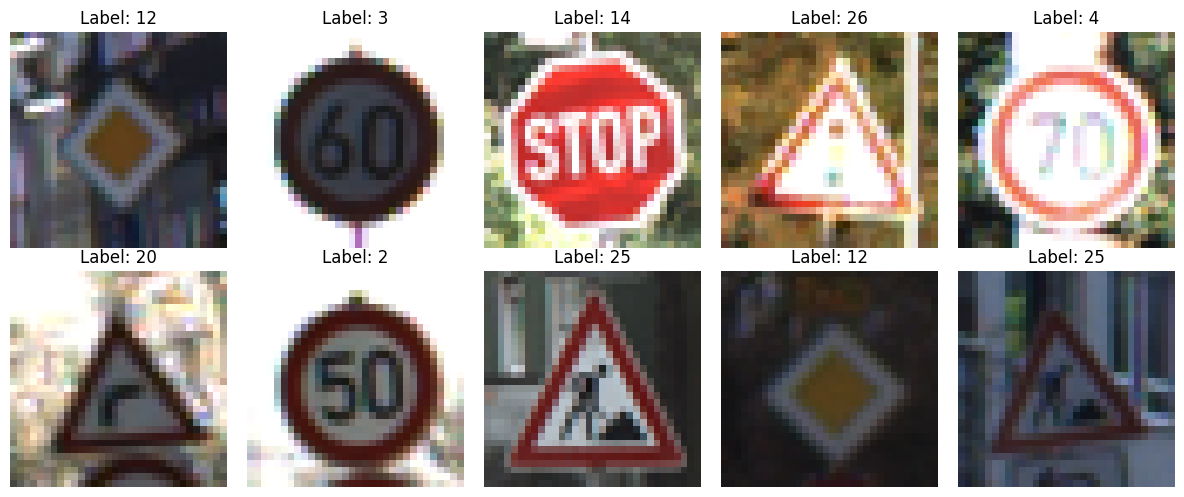

In [5]:
# Preview some images
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i in range(10):
    axs[i//5, i%5].imshow(X_train[i])
    axs[i//5, i%5].set_title(f"Label: {y_train[i]}")
    axs[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

In [6]:
# ===== Data Preprocessing =====
import cv2

# Convert to grayscale
print("Converting to grayscale...")
X_train_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_train])
X_valid_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_valid])
X_test_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_test])

# Normalize pixel values to [0, 1]
X_train_gray = X_train_gray / 255.0
X_valid_gray = X_valid_gray / 255.0
X_test_gray = X_test_gray / 255.0

# Reshape for CNN input (N, H, W, 1)
X_train_gray = X_train_gray.reshape(X_train_gray.shape + (1,))
X_valid_gray = X_valid_gray.reshape(X_valid_gray.shape + (1,))
X_test_gray = X_test_gray.reshape(X_test_gray.shape + (1,))

print("Preprocessing complete!")
print("Training shape:", X_train_gray.shape)

Converting to grayscale...
Preprocessing complete!
Training shape: (26661, 32, 32, 1)


In [7]:
# ===== Build Optimized CNN Model =====
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = models.Sequential([
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001),
                  input_shape=(32, 32, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(43, activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           51

 Total params: 704,651 (2.69 MB)

 Trainable params: 703,243 (2.68 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [8]:
# ===== Compile Model =====
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ===== Set up Callbacks =====
# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

# ===== Train Model =====
print("\nTraining the model...")
history = model.fit(
    X_train_gray, y_train,
    epochs=50,
    validation_data=(X_valid_gray, y_valid),
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Training the model...
Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 204s 942ms/step - accuracy: 0.1032 - loss: 4.9630 - val_accuracy: 0.0599 - val_loss: 4.8122 - learning_rate: 0.0010
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 183s 875ms/step - accuracy: 0.5682 - loss: 2.3127 - val_accuracy: 0.2113 - val_loss: 3.9904 - learning_rate: 0.0010
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 199s 950ms/step - accuracy: 0.8363 - loss: 1.3380 - val_accuracy: 0.9267 - val_loss: 0.9965 - learning_rate: 0.0010
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 185s 884ms/step - accuracy: 0.9219 - loss: 0.9532 - val_accuracy: 0.9842 - val_loss: 0.6726 - learning_rate: 0.0010
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 186s 891ms/step - accuracy: 0.9577 - loss: 0.7512 - val_accuracy: 0.9921 - val_loss: 0.5516 - learning_rate: 0.0010
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 202s 892ms/step - accuracy: 0.9678 - loss: 0.6224 - val_accuracy: 0.9952 - val_loss: 0.4674 - learning_rate: 0.0010
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 1

In [9]:
# ===== Evaluate Performance =====
print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(X_test_gray, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Evaluate on training and validation sets for comparison
train_loss, train_acc = model.evaluate(X_train_gray, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_valid_gray, y_valid, verbose=0)

print(f"\nTraining Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")


Evaluating on test set...
Test Loss: 0.0723
Test Accuracy: 0.9989 (99.89%)

Training Accuracy: 1.0000 (100.00%)
Validation Accuracy: 0.9987 (99.87%)
Test Accuracy: 0.9989 (99.89%)


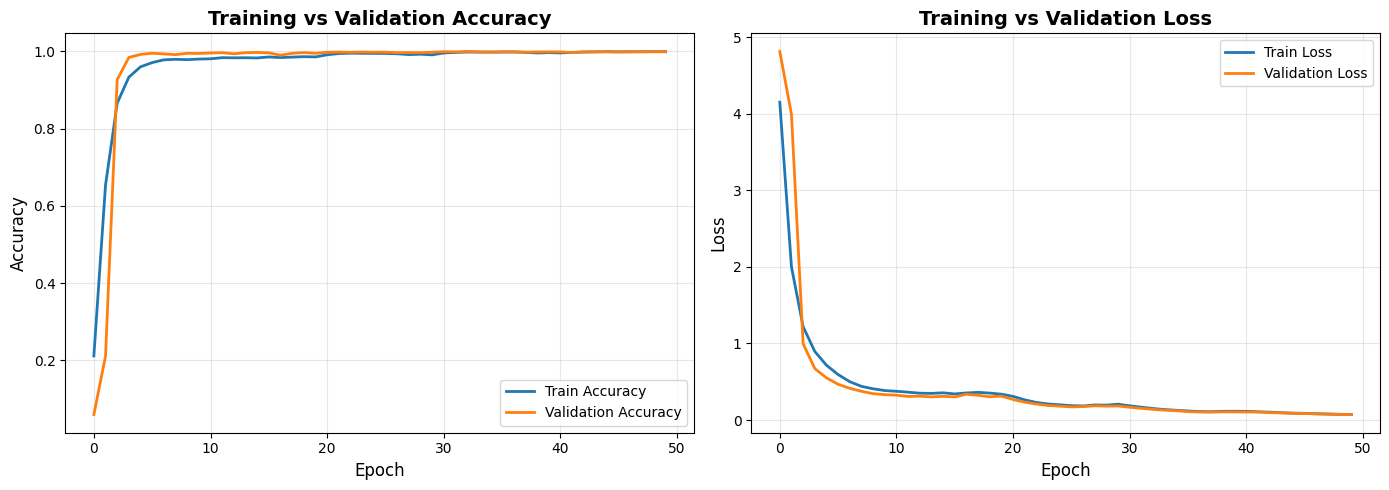

In [10]:
# ===== Plot Training History =====
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Loss plot
ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Generating predictions...


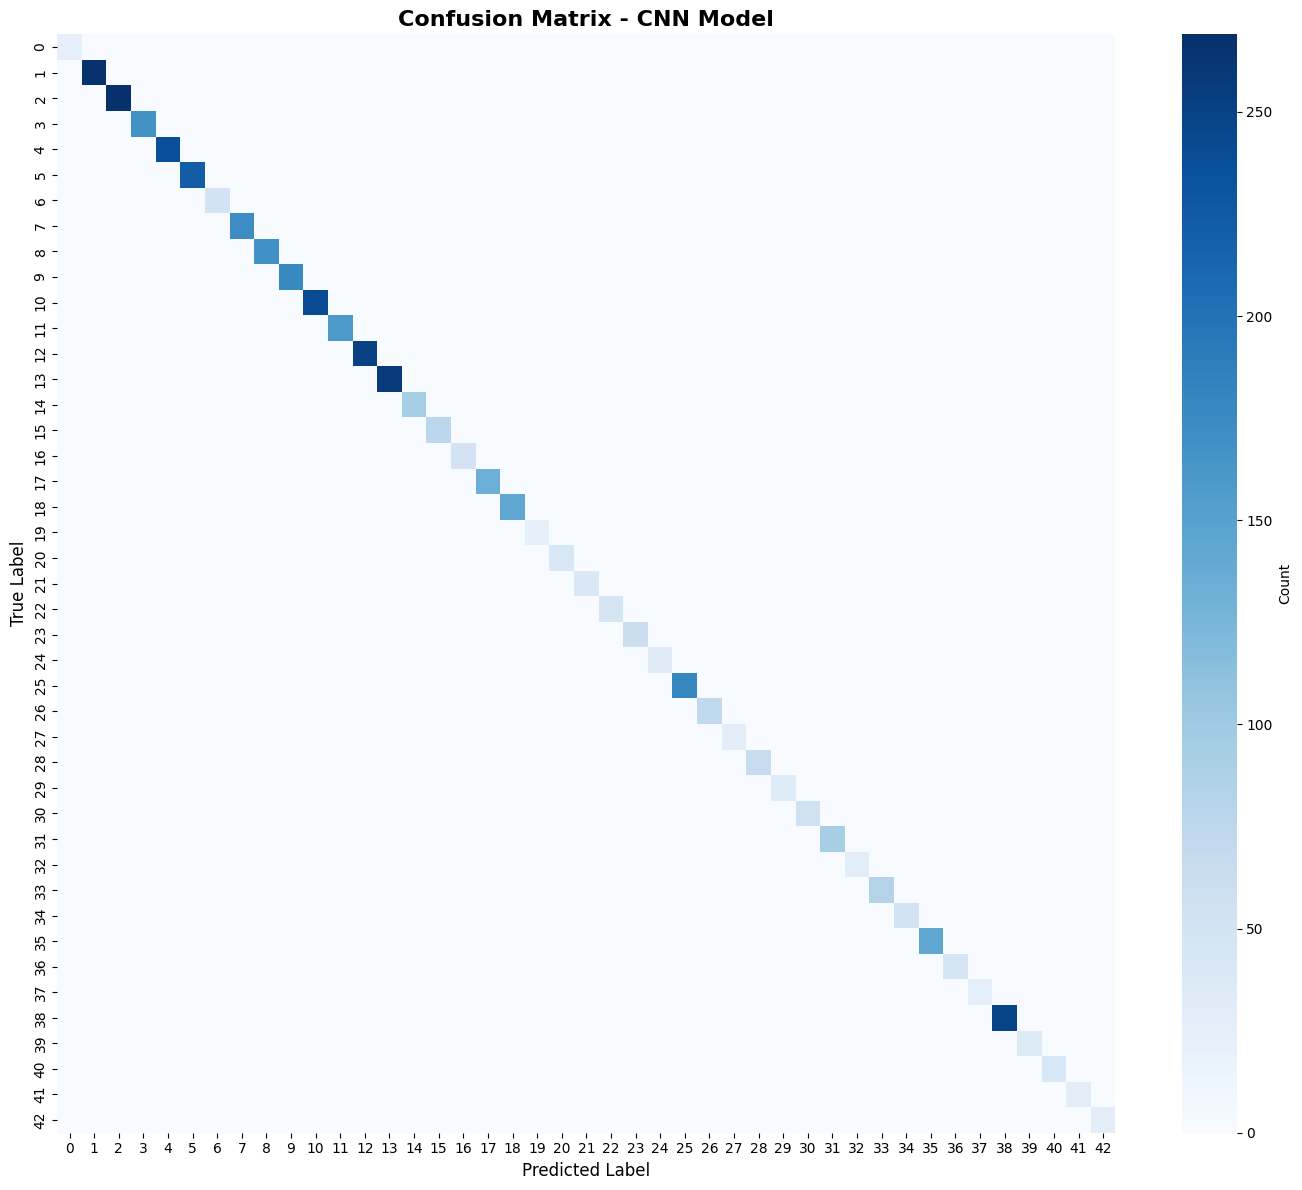


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        25
           1     1.0000    1.0000    1.0000       267
           2     1.0000    0.9963    0.9981       270
           3     1.0000    0.9941    0.9970       169
           4     0.9958    1.0000    0.9979       238
           5     1.0000    0.9955    0.9978       223
           6     1.0000    1.0000    1.0000        50
           7     1.0000    1.0000    1.0000       173
           8     1.0000    1.0000    1.0000       169
           9     1.0000    1.0000    1.0000       177
          10     1.0000    1.0000    1.0000       241
          11     1.0000    1.0000    1.0000       158
          12     1.0000    1.0000    1.0000       252
          13     1.0000    0.9961    0.9981       259
          14     1.0000    1.0000    1.0000        94
          15     0.9870    1.0000    0.9935        76
          16     1.0000    1.0000    1.0000        50
    

In [11]:
# ===== Confusion Matrix & Classification Report =====
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

print("\nGenerating predictions...")
y_pred = np.argmax(model.predict(X_test_gray, verbose=0), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, cmap='Blues', annot=False, fmt='d', cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix - CNN Model", fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Classification Report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred, digits=4))

# ===== Performance Metrics Summary =====
print("\n" + "="*60)
print("PERFORMANCE METRICS SUMMARY")
print("="*60)

metrics_dict = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (Macro)': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'Recall (Macro)': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'F1-Score (Macro)': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'Precision (Weighted)': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'Recall (Weighted)': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'F1-Score (Weighted)': f1_score(y_test, y_pred, average='weighted', zero_division=0)
}

for metric, value in metrics_dict.items():
    print(f"{metric:.<40} {value:.4f} ({value*100:.2f}%)")


In [12]:
# ===== Save the Model =====
model.save('/content/drive/MyDrive/gtsrb/model/traffic_sign_cnn_optimized2.h5')
print("\nModel saved successfully to Google Drive!")


Model saved successfully to Google Drive!


In [13]:
# Save results to a text file
with open('/content/drive/MyDrive/gtsrb/model/cnn_results2.txt', 'w') as f:
    f.write("CNN Model Performance Results\n")
    f.write("="*60 + "\n\n")
    f.write(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)\n")
    f.write(f"Test Loss: {test_loss:.4f}\n\n")
    for metric, value in metrics_dict.items():
        f.write(f"{metric}: {value:.4f} ({value*100:.2f}%)\n")

print("Results saved to cnn_results.txt in Google Drive!")

Results saved to cnn_results.txt in Google Drive!
